# Anomalies in meal prices

In the Chamber of Deputies' CEAP, there is a list of 1,000's of meal expenses made by congresspeople. The law says that the congressperson cannot pay for any other, even being her advisor or SO. We want to work on this analysis to find possibly illegal and immoral expenses. They may have happened when the politician spent more than needed (e.g. the whole menu costs X but the bill was 2X) or too much in an specific period of time. In the end, we also want to alert about too expensive reibursements, even with an explanation behind of it.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('../data/2016-11-19-reimbursements.xz',
                      dtype={'applicant_id': np.str,
                             'cnpj_cpf': np.str,
                             'congressperson_id': np.str,
                             'subquota_number': np.str},
                      low_memory=False)

In [3]:
is_in_brazil = '(-73.992222 < longitude < -34.7916667) & (-33.742222 < latitude < 5.2722222)'
companies = pd.read_csv('../data/2016-09-03-companies.xz',
                        dtype={'cnpj': np.str},
                        low_memory=False)
companies = companies.query(is_in_brazil)
companies['cnpj'] = companies['cnpj'].str.replace(r'\D', '')
dataset = pd.merge(dataset, companies,
                   how='left',
                   left_on='cnpj_cpf',
                   right_on='cnpj',
                   suffixes=('', '_company'))

In [78]:
dataset = \
    dataset.query('subquota_description == "Congressperson meal"')
companies = \
    companies[companies['cnpj'].isin(dataset.loc[dataset['cnpj'].notnull(),
                                                 'cnpj'])]

In [79]:
dataset['total_net_value'].describe()

count    191724.000000
mean         65.758414
std          98.156313
min           0.010000
25%          24.800000
50%          46.060000
75%          85.250000
max        6205.000000
Name: total_net_value, dtype: float64

In [80]:
dataset['total_net_value'].median()

46.06

In [81]:
top_99 = dataset['total_net_value'].quantile(0.99)
top_99

259.86

In [82]:
dataset[dataset['total_net_value'] < top_99].shape

(189805, 259)

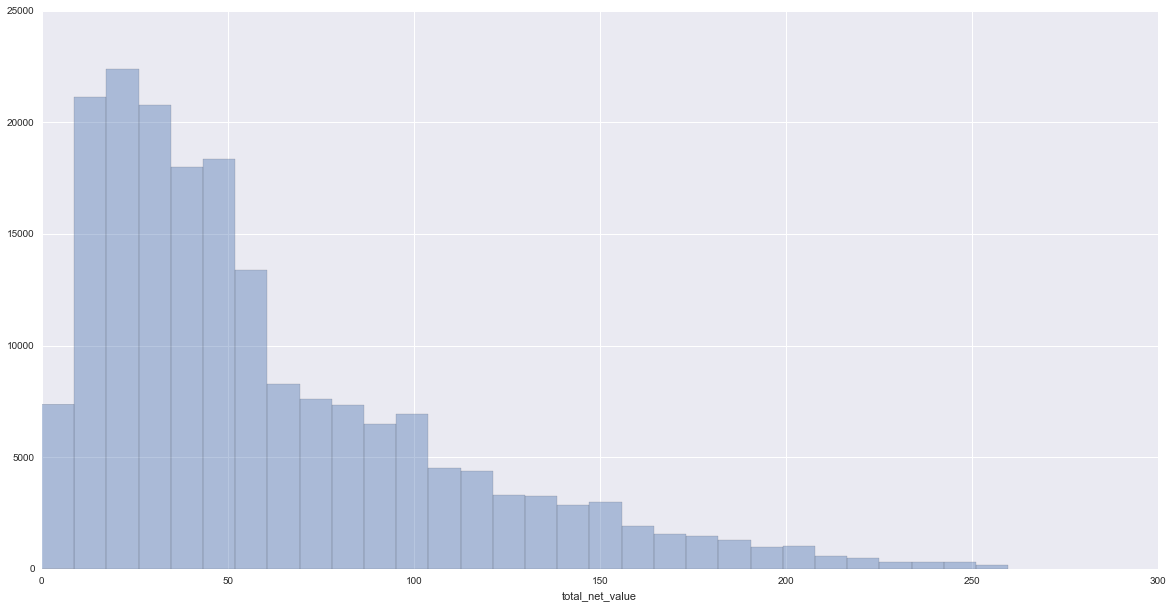

In [83]:
sns.distplot(dataset.loc[dataset['total_net_value'] < top_99, 'total_net_value'],
             bins=30,
             kde=False)

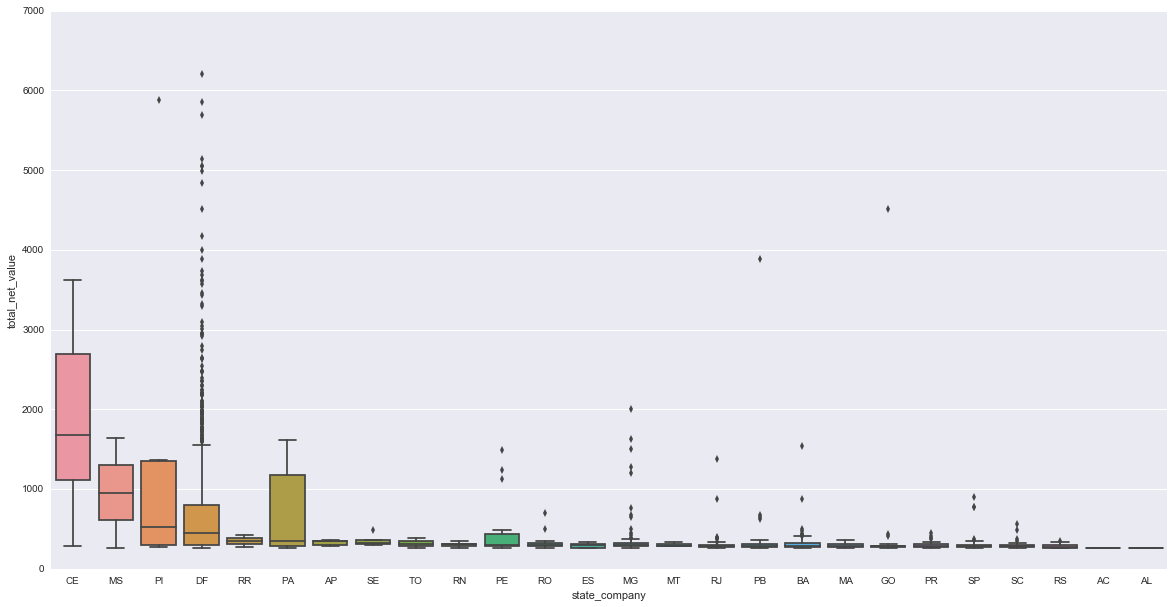

In [84]:
top_99_dataset = dataset.query('total_net_value > {}'.format(top_99))
ranking = top_99_dataset.groupby('state_company')['total_net_value'] \
    .median().sort_values(ascending=False)

sns.boxplot(x='state_company',
            y='total_net_value',
            data=top_99_dataset,
            order=ranking.index)

In [20]:
top_99_dataset.query('state_company == "CE"').shape

(12, 259)

In [22]:
dataset.query('state_company == "CE"').shape

(1438, 259)

In [21]:
top_99_dataset['state_company'].isnull().sum()

192

In [18]:
top_99_dataset.query('state_company == "CE"') \
    .sort_values('total_net_value', ascending=False)

,year,applicant_id,document_id,reimbursement_value_total,total_net_value,reimbursement_numbers,congressperson_name,congressperson_id,congressperson_document,term,...,secondary_activity_97_code,secondary_activity_98,secondary_activity_98_code,secondary_activity_99,secondary_activity_99_code,secondary_activity_9_code,latitude,longitude,latitude.1,longitude.1
23270,2009,1309,1636450,NaN,3623.84,3002,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23291,2009,1309,1681391,NaN,2964.96,3082,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
606810,2012,1309,2427617,NaN,2865.30,4096,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23284,2009,1309,1659987,NaN,2635.52,3046,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803682,2013,1309,5153384,NaN,1978.00,4330,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803671,2013,1309,5125345,NaN,1720.00,4298,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23308,2009,1309,1710377,NaN,1647.20,3116,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803655,2013,1309,5080164,NaN,1634.00,4257,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803670,2013,1309,5125329,NaN,1376.00,4298,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
1403492,2016,1860,6070746,NaN,348.20,5519,JOSÉ AIRTON CIRILO,141464,101.0,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245518,-39.322992,-7.245518,-39.322992


In [29]:
yelp = pd.read_csv('../data/2016-11-29-yelp-companies.xz',
                   low_memory=False)
yelp.head()

,categories,cnpj,coordinates.latitude,coordinates.longitude,distance,id,image_url,is_closed,location.address1,location.address2,...,location.state,location.zip_code,name,phone,price,rating,review_count,scraped_at,trade_name,url
0,"[{'alias': 'pizza', 'title': 'Pizza'}]",94.685.336/0011-50,-30.031437,-51.202667,3188.111070,pizza-hut-porto-alegre,https://s3-media1.fl.yelpcdn.com/bphoto/V5x_9v...,False,R. Castro Alves 791,NaN,...,RS,90430-131,Pizza Hut,5.551332e+11,$$,3.5,3.0,2016-11-28T21:31:50.631166,PIZZA HUT,https://www.yelp.com/biz/pizza-hut-porto-alegr...
1,"[{'alias': 'restaurants', 'title': 'Restaurant...",00.584.490/0001-10,-15.804710,-47.885071,1052.093553,severina-sabor-do-nordeste-brasília,https://s3-media1.fl.yelpcdn.com/bphoto/jJzTOh...,False,CLS 201 BL B lj 25,NaN,...,DF,70232-520,Severina Sabor do Nordeste,5.561322e+11,NaN,4.0,3.0,2016-11-28T21:31:56.262781,SEVERINA O SABOR DO NORDESTE,https://www.yelp.com/biz/severina-sabor-do-nor...
2,"[{'alias': 'restaurants', 'title': 'Restaurant...",01.587.436/0001-91,-15.758420,-47.888321,2948.572720,china-in-box-brasília-2,https://s3-media4.fl.yelpcdn.com/bphoto/PuAPol...,False,SQN 110 BL A lj 20 sl 103,NaN,...,DF,70753-010,China In Box,5.561334e+11,$$,3.5,6.0,2016-11-28T21:31:58.817795,CHINA IN BOX,https://www.yelp.com/biz/china-in-box-bras%C3%...
3,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",08.857.022/0001-84,-12.985820,-38.504559,226913.624760,boi-na-brasa-grill-churrascaria-e-pizzaria-sal...,https://s3-media1.fl.yelpcdn.com/bphoto/Qp7nsI...,False,Bairro Guarani - Liberdade,NaN,...,BA,40327-120,Boi na Brasa Grill - Churrascaria e Pizzaria,5.571326e+11,NaN,4.0,1.0,2016-11-28T21:32:05.065876,CHURRASCARIA BOI NA BRASA,https://www.yelp.com/biz/boi-na-brasa-grill-ch...
4,"[{'alias': 'pizza', 'title': 'Pizza'}]",00.941.379/0001-34,-22.824841,-43.049351,2.055793,rodo-grill-são-gonçalo,NaN,False,R. Doutor Feliciano Sodré 115,NaN,...,RJ,24440-440,Rodo Grill,5.521261e+11,NaN,5.0,1.0,2016-11-28T21:32:14.769193,RODO GRILL,https://www.yelp.com/biz/rodo-grill-s%C3%A3o-g...


We have data for just 8.6% of the companies which received from the "Congressperson meal" subquota.

In [66]:
yelp['price'].notnull().sum()

1563

In [77]:
companies.shape

(18037, 228)

In [30]:
yelp['price'].isnull().sum()

10651

In [58]:
yelp['price.int'] = yelp['price'].str.len()
states_with_records = \
    yelp[yelp['price'].notnull()].groupby('location.state')['location.state'].count() > 10
states_with_records = states_with_records[states_with_records].index

In [64]:
yelp_just_significant_states = \
    yelp[yelp['price'].notnull() &
         yelp['location.state'].isin(states_with_records)]
yelp_just_significant_states['location.state'].value_counts()

DF    410
SP    277
RJ    197
BA    158
PR    114
RS     93
PE     90
MG     57
CE     52
SC     32
PB     18
RN     13
GO     12
PA     12
Name: location.state, dtype: int64

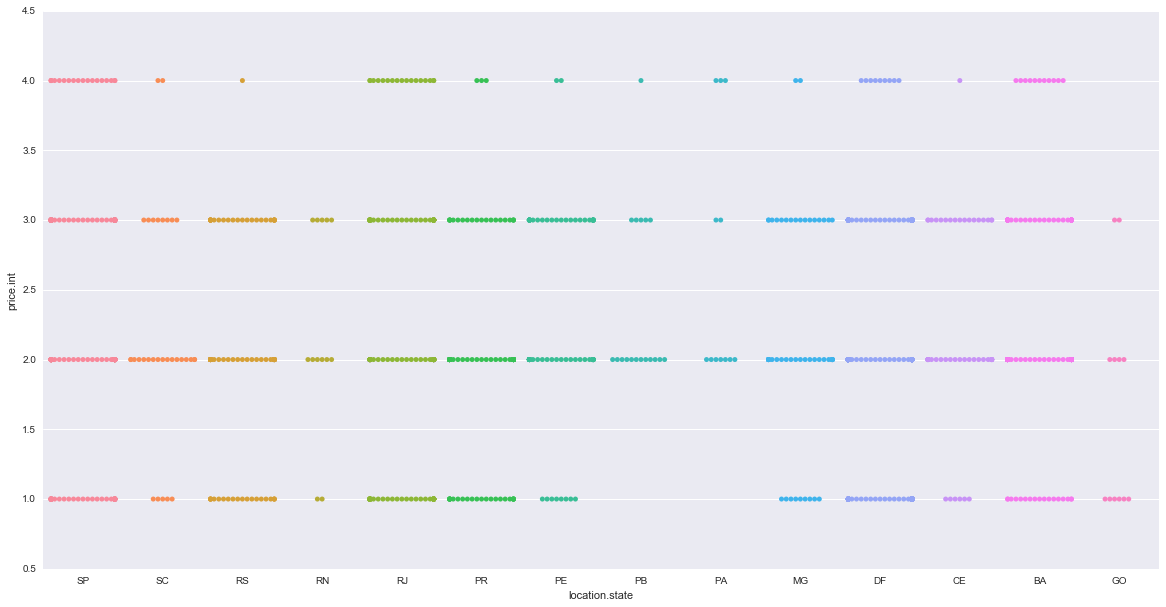

In [65]:
yelp_ranking = yelp_just_significant_states.groupby('location.state')['price.int'] \
    .median().sort_values(ascending=False)
    
sns.swarmplot(x='location.state',
              y='price.int',
              data=yelp_just_significant_states,
              order=yelp_ranking.index)